#202318044


#Hani Soni

In [21]:
!pip install pyspark

In [43]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, Word2Vec
from pyspark.ml.clustering import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [44]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Document clustering") \
    .getOrCreate()

Fetching dataset

In [45]:
data_newsgroup = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Convert data into a DataFrame
data = pd.DataFrame({'text': data_newsgroup.data})

# Convert pandas DataFrame to Spark DataFrame
processed_data = spark.createDataFrame(data)


In unsupervised learning, we employ clustering algorithms on the complete dataset to unveil intrinsic structures or patterns within the data. Unlike supervised learning where we partition the dataset into training and testing sets, in this approach, we utilize the entirety of the dataset for clustering analysis.

Represnting each document using the TF-IDF.

In [46]:
# Document Representation (TF-IDF)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(processed_data)
wordsData

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filteredData = remover.transform(wordsData)

In [47]:
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
featurizedData = hashingTF.transform(filteredData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
tfidfData = idfModel.transform(featurizedData)

K-means clustering

In [48]:
kmeans = KMeans(featuresCol="features").setK(5)
model = kmeans.fit(tfidfData)
predictions = model.transform(tfidfData)  #making predictions
tfidfData.select("features").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

The silhouette score serves as a metric for assessing the effectiveness of clustering algorithms. It gauges the cohesion of objects within their respective clusters and their separation from neighboring clusters. Scores range from -1 to 1:

•A score nearing +1 signifies strong cohesion within the cluster and considerable separation from adjacent clusters, indicative of robust clustering.

•A score nearing 0 suggests the object resides near the boundary between neighboring clusters.

•A score nearing -1 implies potential misassignment of the object to an incorrect cluster.

In [49]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# Evaluate silhouette score
silhouette_score = evaluator.evaluate(predictions)
print("Silhouette Score:", silhouette_score)

Silhouette Score: 0.9914978734281673


In [50]:
#  Finding optimal K for K-means (Elbow Method)
wcss = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol='features').setK(k).setSeed(1)
    model = kmeans.fit(tfidfData)
    wcss_value = model.summary.trainingCost
    # Get the WCSS (within-set sum of squared errors) from the summary
    wcss.append(wcss_value)

In [51]:
print("All K values along with their corresponding WCSS:")
for k, wcss_value in zip(range(2, 11), wcss):
    print(f"K = {k}, WCSS = {wcss_value}")

All K values along with their corresponding WCSS:
K = 2, WCSS = 352773601.9862516
K = 3, WCSS = 336776685.0973142
K = 4, WCSS = 324826816.80240023
K = 5, WCSS = 321553782.6812318
K = 6, WCSS = 254583304.39911497
K = 7, WCSS = 256953927.98378813
K = 8, WCSS = 236066415.47038233
K = 9, WCSS = 233250568.31516588
K = 10, WCSS = 230067357.55385324


As the number of clusters (K) increases, the within-cluster sum of squares (WCSS) typically decreases. This trend is anticipated as a greater number of clusters enables a more precise fitting of the data points, leading to reduced variations within each cluster.

#Elbow method:

The Elbow method is a heuristic used to find the optimal number of clusters (k) in a dataset for clustering algorithms.

In the context of K-means clustering, the number of clusters (K) serves as a hyperparameter. To determine the optimal value for K, we compute the within-cluster sum of squares (WCSS) for various values of K. Subsequently, we employ the elbow method to identify the point at which the rate of decrease in WCSS slows down, indicating an optimal number of clusters.

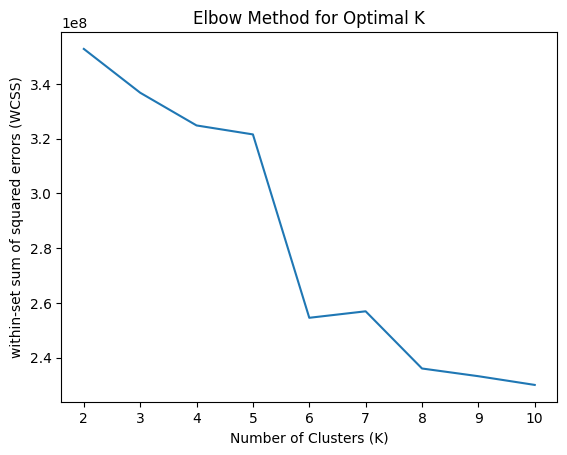

Optimal K value: 10


In [52]:
# Plotting the elbow method
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('within-set sum of squared errors (WCSS)')
plt.show()
optimal_k = wcss.index(min(wcss)) + 2  # Add 2 because the range starts from 2
print("Optimal K value:", optimal_k)

Initially, as the number of clusters (K) increases, the within-cluster sum of squares (WCSS) values tend to decrease. However, beyond a certain point, often referred to as the elbow point, the rate of decrease in WCSS slows down. This signifies diminishing returns in terms of reducing WCSS with additional clusters. In the context of our analysis, we observe the elbow point at K = 10, suggesting that further increasing the number of clusters may not notably enhance the clustering performance.

Agglomerative clustering for clustering the documents and find the optimal number of clusters using dendogram diagrams.

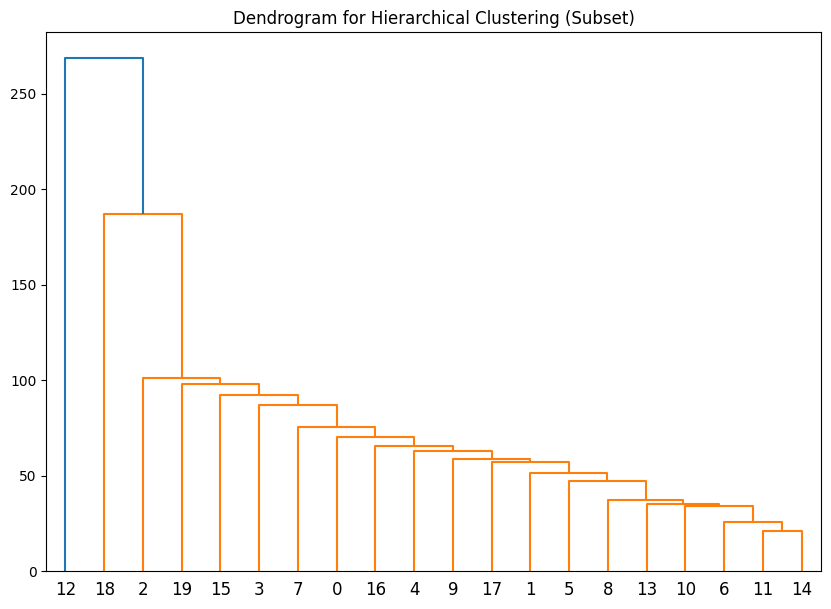

Optimal number of clusters (K): 20


In [53]:
# Sample a subset of the TF-IDF matrix
subset_size = 20  # Adjust the subset size as needed
subset_indices = np.random.choice(tfidfData.count(), size=subset_size, replace=False)
subset_features = tfidfData.select('features').take(subset_size)

# Convert subset features to array
subset_array = [row.features.toArray() for row in subset_features]

# Perform hierarchical clustering on the subset
Z = linkage(subset_array, method='ward')

# Plotting dendrogram for hierarchical clustering on the subset
plt.figure(figsize=(10, 7))
plt.title("Dendrogram for Hierarchical Clustering (Subset)")
dendrogram(Z)
plt.show()

num_vertical_lines = 0
for i in range(len(Z)):
    if Z[i][2] > 0:
        num_vertical_lines += 1

# Optimal number of clusters is the number of vertical lines + 1
optimal_k = num_vertical_lines + 1
print("Optimal number of clusters (K):", optimal_k)

Naive Bayes Classification

In [54]:
# TF-IDF Vectorization for Naive Bayes classification
data = pd.DataFrame({'text': data_newsgroup.data, 'target': data_newsgroup.target})

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
y_pred_nb = nb_classifier.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Classification Accuracy:", accuracy_nb)

Naive Bayes Classification Accuracy: 0.5419098143236074


In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calculate precision
precision = precision_score(y_test, y_pred_nb, average='weighted')

# Calculate recall
recall = recall_score(y_test, y_pred_nb, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test, y_pred_nb, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)

print("Naive Bayes Classification Metrics:")
print("Accuracy:", accuracy_nb)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Naive Bayes Classification Metrics:
Accuracy: 0.5419098143236074
Precision: 0.5690395855033833
Recall: 0.5419098143236074
F1-score: 0.5349491510222599
Confusion Matrix:
[[ 56   0   1   0   0   1   0   4  12   2   1   0   0  10   3  41  11   6
    3   0]
 [  4 104  20   7   2  11   5   4  11   2   2   3  10   8   7   2   0   0
    0   0]
 [  2  17 112  18   5  15   3   1  10   1   0   1   2   6   0   2   0   0
    0   0]
 [  0  16  26  93  16   5   5   3   1   0   0   0  13   3   0   2   0   0
    0   0]
 [  2  11   7  38  90   3   7   6  15   1   0   4   8   4   7   2   0   0
    0   0]
 [  0  28  18   3   2 143   0   1   7   1   1   3   2   2   1   2   0   1
    0   0]
 [  0   3   1  15   7   5 133   4   5   2   0   3   9   0   4   0   1   0
    1   0]
 [  5   3   1   2   0   3   6 104  35   3   0   2   4   9   7   4   7   0
    1   0]
 [  3   3   1   4   1   1   6  15  98   9   7   1   3   5   2   1   5   2
    1   0]
 [  5   2   0   1   0   0   6   3  19 109  31   0   5  13   2   9 

In [56]:
# Word2Vec Embedding
word2vec_model = Word2Vec(vectorSize=10, minCount=1, inputCol="words", outputCol="word_vectors")
word2vec_model = word2vec_model.fit(wordsData)
word2vec_vectors = word2vec_model.transform(wordsData)

K-means using word2Vec

In [57]:
kmeans_word2vec = KMeans(featuresCol="word_vectors", k=5)  # Assuming k=5 clusters
model_word2vec = kmeans_word2vec.fit(word2vec_vectors)
predictions_word2vec = model_word2vec.transform(word2vec_vectors)

In [58]:
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="word_vectors")
silhouette_word2vec = evaluator.evaluate(predictions_word2vec)
print("Silhouette score for Word2Vec-based K-means clustering:", silhouette_word2vec)

Silhouette score for Word2Vec-based K-means clustering: 0.32402315877520815


In [59]:
spark.stop()

In [60]:
!pip install transformers